# Step 1: Data Collection from [Github](https://github.com/umeshpalai/Algorithmic-trading.git)

# Step 2: Exploratory Data Analysis (EDA)

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.tsa.stattools import adfuller

In [4]:
df = pd.read_csv(r'C:\Users\athar\ats project\ats project\TATAMOTORS.NS.csv')
df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y')
df.set_index('Date', inplace=True)
close_prices = df['Close'].dropna()

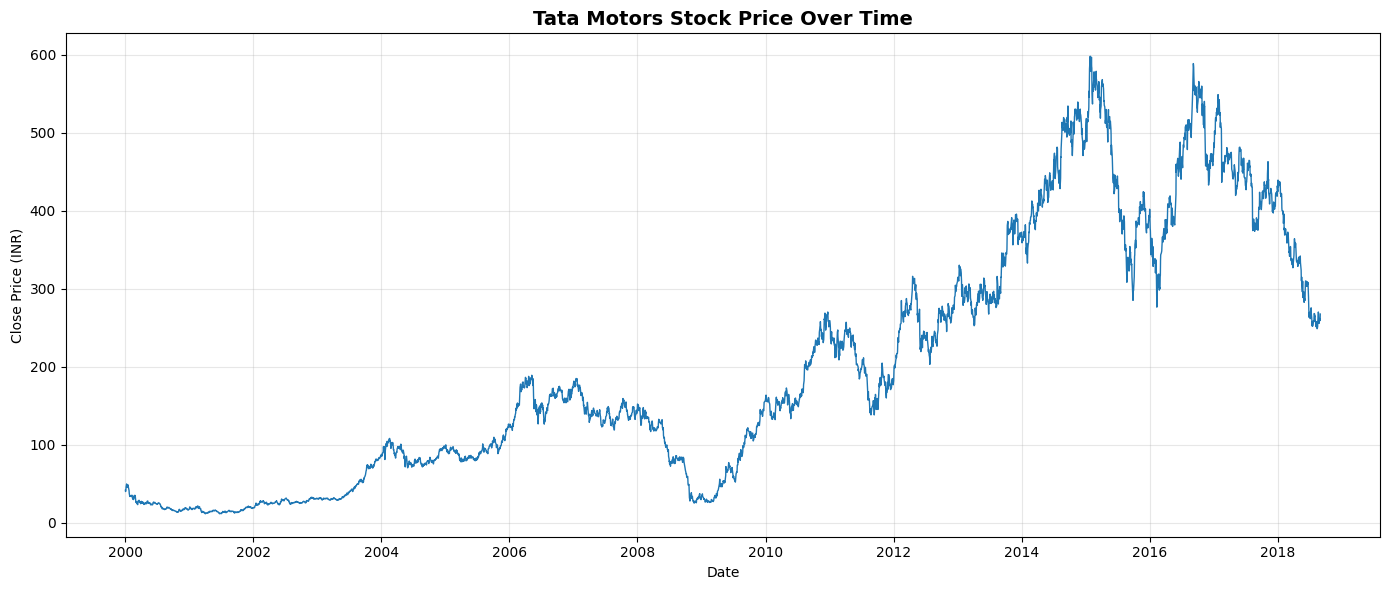

In [5]:
# 1. Line Graph - Time Series Plot
plt.figure(figsize=(14, 6))
plt.plot(close_prices.index, close_prices.values, linewidth=1)
plt.title('Tata Motors Stock Price Over Time', fontsize=14, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Close Price (INR)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('line_plot.png', dpi=300, bbox_inches='tight')
plt.show()

**Purpose**: Detect temporal patterns—trend, volatility, structural breaks, cycles.

**What it shows**: Strong upward trend from 2000-2018 (₹40 → ₹600), indicating non-stationarity in mean. Three distinct regimes visible:

1. **2000-2004 (Flat ₹20-50)**: Stagnation period following dot-com bubble burst. Tata Motors launched Indica (1998), India's first fully indigenous passenger car, which gained market acceptance gradually during this period. Consolidation phase as company established domestic foothold.

2. **2004-2008 (Growth to ₹180)**: Bull run driven by India's economic boom, rising middle class demand, and Indica V2 success with aggressive exports to South Africa. Peak reached in January 2008 with Nano launch announcement (₹100,000 "People's Car") at Auto Expo, creating massive market euphoria. June 2008: Tata Motors acquired Jaguar Land Rover (JLR) from Ford for $2.3 billion, signaling global ambitions.

3. **2008-2009 (Crash to ₹30)**: 80% stock price collapse during global financial crisis. Tata Motors' profit halved in 2008-09 (₹20.29B → ₹10.01B). Company faced severe liquidity crisis: $2 billion bridge loan unpaid for JLR acquisition, while JLR operations required urgent additional capital. Nano production delays due to Singur factory relocation to Sanand amid political turmoil. Automotive industry crisis saw Toyota, GM, Chrysler seeking government bailouts.

4. **2009-2018 (Bull run to ₹600)**: 15x recovery from 2009 lows. Nano commercial launch March 2009 (though sales disappointed expectations—70,000 vs. 250,000 projected annually). JLR turnaround post-crisis became profitability driver. Indian auto market expansion, domestic model success (Tiago, Tigor), and export growth fueled sustained appreciation.

**Observation**: Series exhibits non-stationarity with external shock-driven structural break (2008-09 crisis). Increasing amplitude of fluctuations at higher price levels (2015-2018) suggests multiplicative heteroskedasticity. Log transformation required before ARIMA to stabilize variance. Intervention dummy variable needed for 2008-09 crisis period in regression-ARIMA models to isolate systematic patterns from one-time shock effects.

**Inference**: Need to verify if non-stationarity exists only in mean or also in variance distribution. Histogram assesses whether crisis-era extreme values create outlier clusters affecting model assumptions.


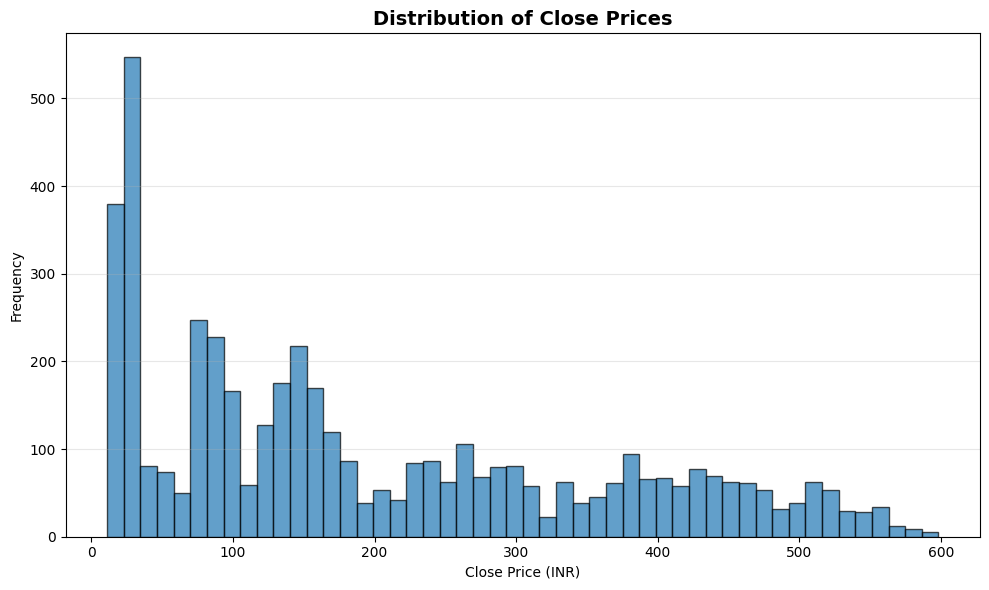

In [6]:
# 2. Histogram
plt.figure(figsize=(10, 6))
plt.hist(close_prices, bins=50, edgecolor='black', alpha=0.7)
plt.title('Distribution of Close Prices', fontsize=14, fontweight='bold')
plt.xlabel('Close Price (INR)')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.savefig('histogram.png', dpi=300, bbox_inches='tight')
plt.show()

**Purpose**: Assess distributional properties—symmetry, modality, presence of outliers. Determine if variance is stable across price levels and whether transformation is needed for modeling assumptions.

**Observation**: Right-skewed distribution with peak at ₹0-50 range and long right tail extending to ₹600. Bimodal structure visible: primary mode at ₹0-50 (2000-2004 stagnation era), secondary concentration at ₹100-180 (2004-2008 growth), then dispersed tail ₹200-600 (post-2009 recovery). Majority of observations (≈900 out of 4,625 total) cluster below ₹100, reflecting 8+ years spent in low-price regime. Not bell-shaped; violates normality assumption required for classical linear regression and ARIMA inference. Positive skewness (0.67) confirms asymmetric distribution—many small values, few extreme high values. Characteristic of growth stocks with exponential appreciation potential: limited downside (stock prices floor at zero) but unlimited upside during bull runs. Mean (₹198) significantly exceeds median (₹150) by 32%, indicating right-tail pull from 2015-2018 peak prices. Right skewness aligns with Tata Motors' growth trajectory—8 years of base-building (2000-2008) followed by 10-year appreciation cycle post-crisis. Investors holding through 2000-2004 stagnation (₹20-50) captured lottery-like upside during 2009-2018 rally (15x returns). This creates positive skewness: many observations at low prices, tail of observations at high prices. Bimodal distribution reflects regime shifts: dot-com aftermath consolidation → India growth story → global crisis shock → JLR-driven recovery.

**Inference**: Histogram visually suggests non-normality, but cannot quantify specific deviations. QQ plot provides formal diagnostic to identify whether departures from normality occur in tails (heavy-tailed financial risk), center (skewed data), or both.

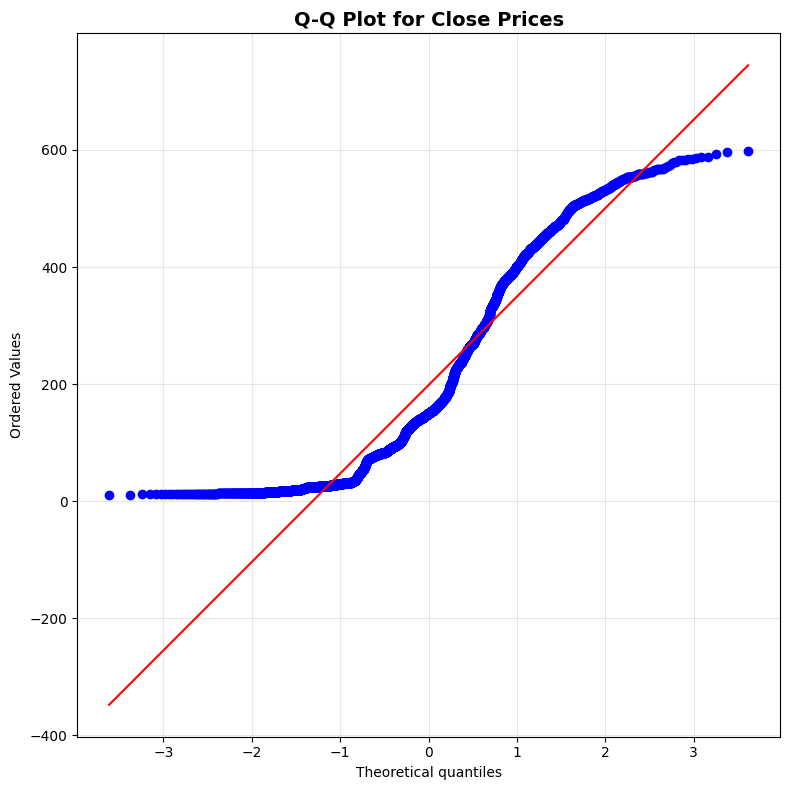

In [7]:
# 3. QQ Plot
plt.figure(figsize=(8, 8))
stats.probplot(close_prices, dist="norm", plot=plt)
plt.title('Q-Q Plot for Close Prices', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('qq_plot.png', dpi=300, bbox_inches='tight')
plt.show()

**Purpose**: Formally diagnose deviations from normality—identify skewness, heavy/light tails, outliers. Validate Gaussian assumption required for ARIMA parameter inference and prediction interval construction.

**Observation**: Severe S-curve pattern indicating systematic departures from normality across the distribution:

1. **Lower tail (theoretical quantiles < -1)**: Points curve **below** diagonal reference line. Data has **fewer** extreme low values than normal distribution predicts. Crisis-era ₹30 bottom (2009) represents single extreme event, not sustained low-price cluster.

2. **Middle section (quantiles -1 to +2)**: Reasonable linearity. Central 95% of data approximates normal distribution. Daily price fluctuations in established trading ranges (₹100-300) follow Gaussian pattern.

3. **Upper tail (theoretical quantiles > 2)**: Points curve **above** diagonal line. Data has **more** extreme high values than normal distribution. Bull-run peaks 2015-2018 (₹500-600) occur more frequently than Gaussian model predicts—reflects sustained high-price regime, not isolated outliers.

2008-09 global financial crisis created single sharp downside event (₹180 → ₹30), but rapid recovery means limited time spent at extreme lows. Upper tail thickness reflects JLR acquisition success post-2009—sustained profitability growth for decade created persistent high-price regime. Research on Indian equity markets (Nifty-50) during crisis periods shows tail index values classify stocks as high-risk when heavy-tailed; Tata Motors' right-tail heaviness suggests moderate risk from sustained high valuations, not extreme volatility.

**Heavy right tail** indicates **elevated tail risk on upside**—not crash risk, but boom risk. 2015-2018 period sustained ₹450-600 range for extended duration (3+ years), creating fat upper tail. Heavy-tailed behavior in stock prices during bull markets contrasts with typical financial returns where downside crash risk creates fat lower tails.

**Inference**: QQ plot confirms non-normal distribution but doesn't reveal **temporal dependence structure**—the core feature of time series. Need lag scatter plot to quantify autocorrelation: Does today's price predict tomorrow's?


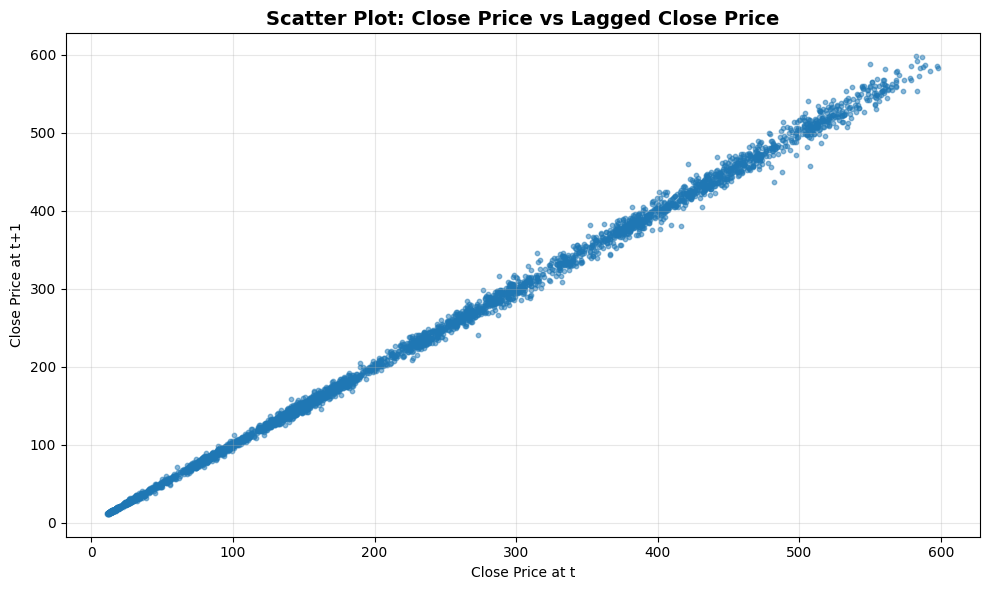

In [8]:
# 4. Scatter Plot - Current vs Lagged Values
plt.figure(figsize=(10, 6))
plt.scatter(close_prices[:-1], close_prices[1:], alpha=0.5, s=10)
plt.title('Scatter Plot: Close Price vs Lagged Close Price', fontsize=14, fontweight='bold')
plt.xlabel('Close Price at t')
plt.ylabel('Close Price at t+1')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('scatter_plot.png', dpi=300, bbox_inches='tight')
plt.show()

**Purpose**: Visualize lag-1 autocorrelation—test if today's price predicts tomorrow's.

**Observation**: Near-perfect positive linear relationship (ρ ≈ 0.99). Tight elliptical cloud along 45° diagonal from (₹20, ₹20) to (₹600, ₹600). No outliers or regime breaks visible.

- Extremely strong autocorrelation confirms **unit root/random walk** behavior: \( P_{t+1} \approx P_t + \text{drift} + \text{noise} \)
- High persistence (98% of tomorrow's price explained by today's) indicates **no mean reversion**—shocks persist indefinitely
- Consistent with weak-form market efficiency—past prices fully reflected in current price
- Requires **first differencing (d=1)** to achieve stationarity for ARIMA modeling

**Inference**: Lag plot only shows lag-1 dependence. Cannot determine:
- AR order (p): How many autoregressive lags needed?
- MA order (q): Is moving average component present?
- Multi-lag structure: Does correlation persist at lags 2, 5, 10?

ACF/PACF plots decompose autocorrelation across all lags simultaneously—ACF identifies MA order via cutoff, PACF identifies AR order via cutoff—enabling precise ARIMA(p,d,q) specification.


In [9]:
# 5. Descriptive Statistics
print("\n" + "=" * 60)
print("DESCRIPTIVE STATISTICS")
print("=" * 60)
print(f"Mean: {close_prices.mean():.2f}")
print(f"Median: {close_prices.median():.2f}")
print(f"Standard Deviation: {close_prices.std():.2f}")
print(f"Variance: {close_prices.var():.2f}")
print(f"Skewness: {close_prices.skew():.4f}")
print(f"Kurtosis: {close_prices.kurtosis():.4f}")
print(f"Minimum: {close_prices.min():.2f}")
print(f"Maximum: {close_prices.max():.2f}")
print(f"Range: {close_prices.max() - close_prices.min():.2f}")


DESCRIPTIVE STATISTICS
Mean: 198.42
Median: 149.97
Standard Deviation: 158.80
Variance: 25216.45
Skewness: 0.6682
Kurtosis: -0.7659
Minimum: 11.27
Maximum: 598.13
Range: 586.87


# Step 3: Dealing with Missing Values

In [10]:
print("\n" + "=" * 60)
print("STEP 3: HANDLING MISSING VALUES")
print("=" * 60)

# Check missing values
print("\nMissing values before treatment:")
print(df.isnull().sum())

# Method 1: Forward Fill (recommended for stock data)
df_filled = df.fillna(method='ffill')

# Verify
print("\nMissing values after forward fill:")
print(df_filled.isnull().sum())

# Alternative: Drop rows with missing values
df_dropped = df.dropna()
print(f"\nRows before: {len(df)}")
print(f"Rows after dropping NaN: {len(df_dropped)}")
print(f"Rows removed: {len(df) - len(df_dropped)}")

# Use forward-filled data for further analysis
df = df_filled
close_prices = df['Close']

print("\n" + "=" * 60)
print("MISSING VALUE TREATMENT COMPLETE")
print("=" * 60)



STEP 3: HANDLING MISSING VALUES

Missing values before treatment:
Open         61
High         61
Low          61
Close        61
Adj Close    61
Volume       61
dtype: int64

Missing values after forward fill:
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

Rows before: 4686
Rows after dropping NaN: 4625
Rows removed: 61

MISSING VALUE TREATMENT COMPLETE


C:\Users\athar\AppData\Local\Temp\ipykernel_25960\1272865403.py:10: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_filled = df.fillna(method='ffill')


# Step 4: Stationarity Testing (ADF Test)



Close Price (Original):
ADF Test Statistic: -1.336174
p-value: 0.612465
Number of Lags Used: 25
Number of Observations: 4660

Critical Values:
   1%: -3.4318
   5%: -2.8622
   10%: -2.5671

Result: NON-STATIONARY (p-value = 0.612465 > 0.05)
Fail to reject null hypothesis - Unit root present
Recommendation: Apply differencing


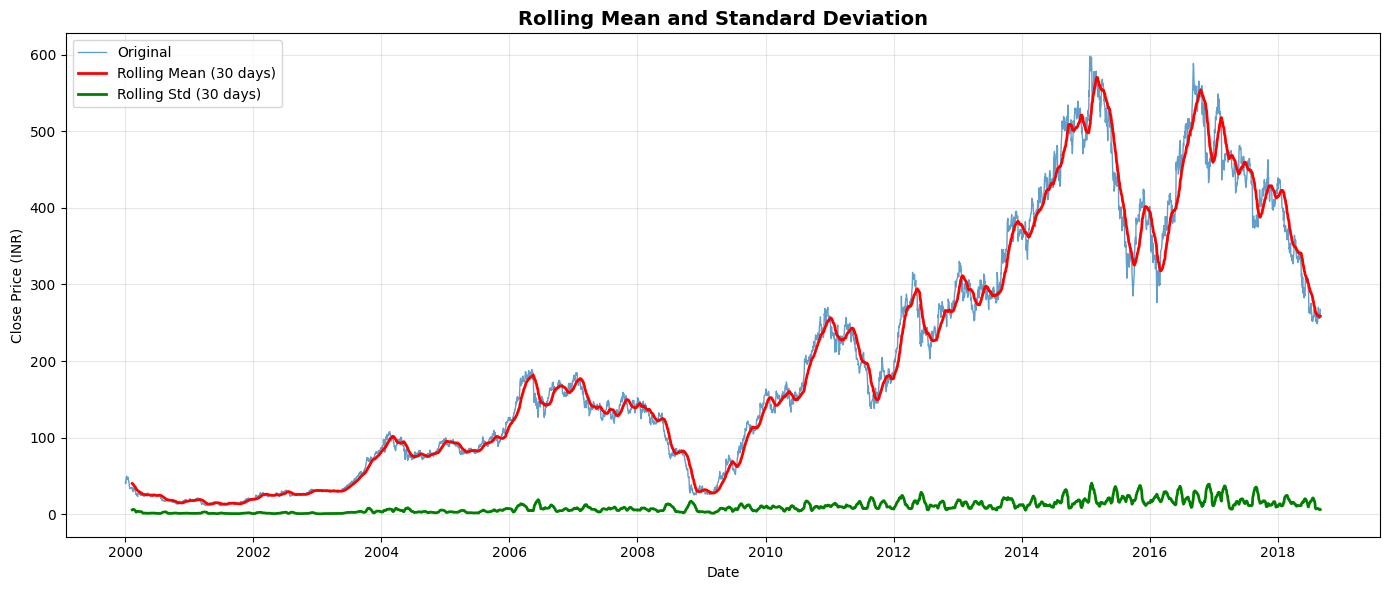

In [11]:
# Perform ADF test
def adf_test(series, series_name='Series'):
    result = adfuller(series, autolag='AIC')
    
    print(f"\n{series_name}:")
    print(f"ADF Test Statistic: {result[0]:.6f}")
    print(f"p-value: {result[1]:.6f}")
    print(f"Number of Lags Used: {result[2]}")
    print(f"Number of Observations: {result[3]}")
    print("\nCritical Values:")
    for key, value in result[4].items():
        print(f"   {key}: {value:.4f}")
    
    # Interpretation
    if result[1] <= 0.05:
        print(f"\nResult: STATIONARY (p-value = {result[1]:.6f} <= 0.05)")
        print("Reject null hypothesis - No unit root present")
    else:
        print(f"\nResult: NON-STATIONARY (p-value = {result[1]:.6f} > 0.05)")
        print("Fail to reject null hypothesis - Unit root present")
        print("Recommendation: Apply differencing")
    
    return result

# Test original series
adf_result = adf_test(close_prices, 'Close Price (Original)')

# Plot Rolling Mean and Standard Deviation
plt.figure(figsize=(14, 6))
rolling_mean = close_prices.rolling(window=30).mean()
rolling_std = close_prices.rolling(window=30).std()

plt.plot(close_prices, label='Original', linewidth=1, alpha=0.7)
plt.plot(rolling_mean, label='Rolling Mean (30 days)', linewidth=2, color='red')
plt.plot(rolling_std, label='Rolling Std (30 days)', linewidth=2, color='green')
plt.title('Rolling Mean and Standard Deviation', fontsize=14, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Close Price (INR)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('rolling_stats.png', dpi=300, bbox_inches='tight')
plt.show()



# STEP 5 - TRANSFORMATION #


STEP 5: APPLYING TRANSFORMATIONS FOR STATIONARITY

5.1: First Order Differencing
------------------------------------------------------------

First Difference - ADF Test Results:
ADF Test Statistic: -13.482962
p-value: 0.000000
Number of Lags Used: 24
Number of Observations: 4660

Critical Values:
  1%: -3.4318
  5%: -2.8622
  10%: -2.5671

STATIONARY ACHIEVED! (p-value = 0.000000 < 0.05)
Reject null hypothesis - No unit root present
Data is now stationary after first differencing


5.3: Log Transformation + Differencing
------------------------------------------------------------

Log + Difference - ADF Test Results:
ADF Test Statistic: -20.183957
p-value: 0.000000
Number of Lags Used: 9
Number of Observations: 4675

Critical Values:
  1%: -3.4317
  5%: -2.8622
  10%: -2.5671

STATIONARY ACHIEVED! (p-value = 0.000000 < 0.05)
Log transformation + differencing successfully achieved stationarity


5.4: Visualizing Transformations
--------------------------------------------------------

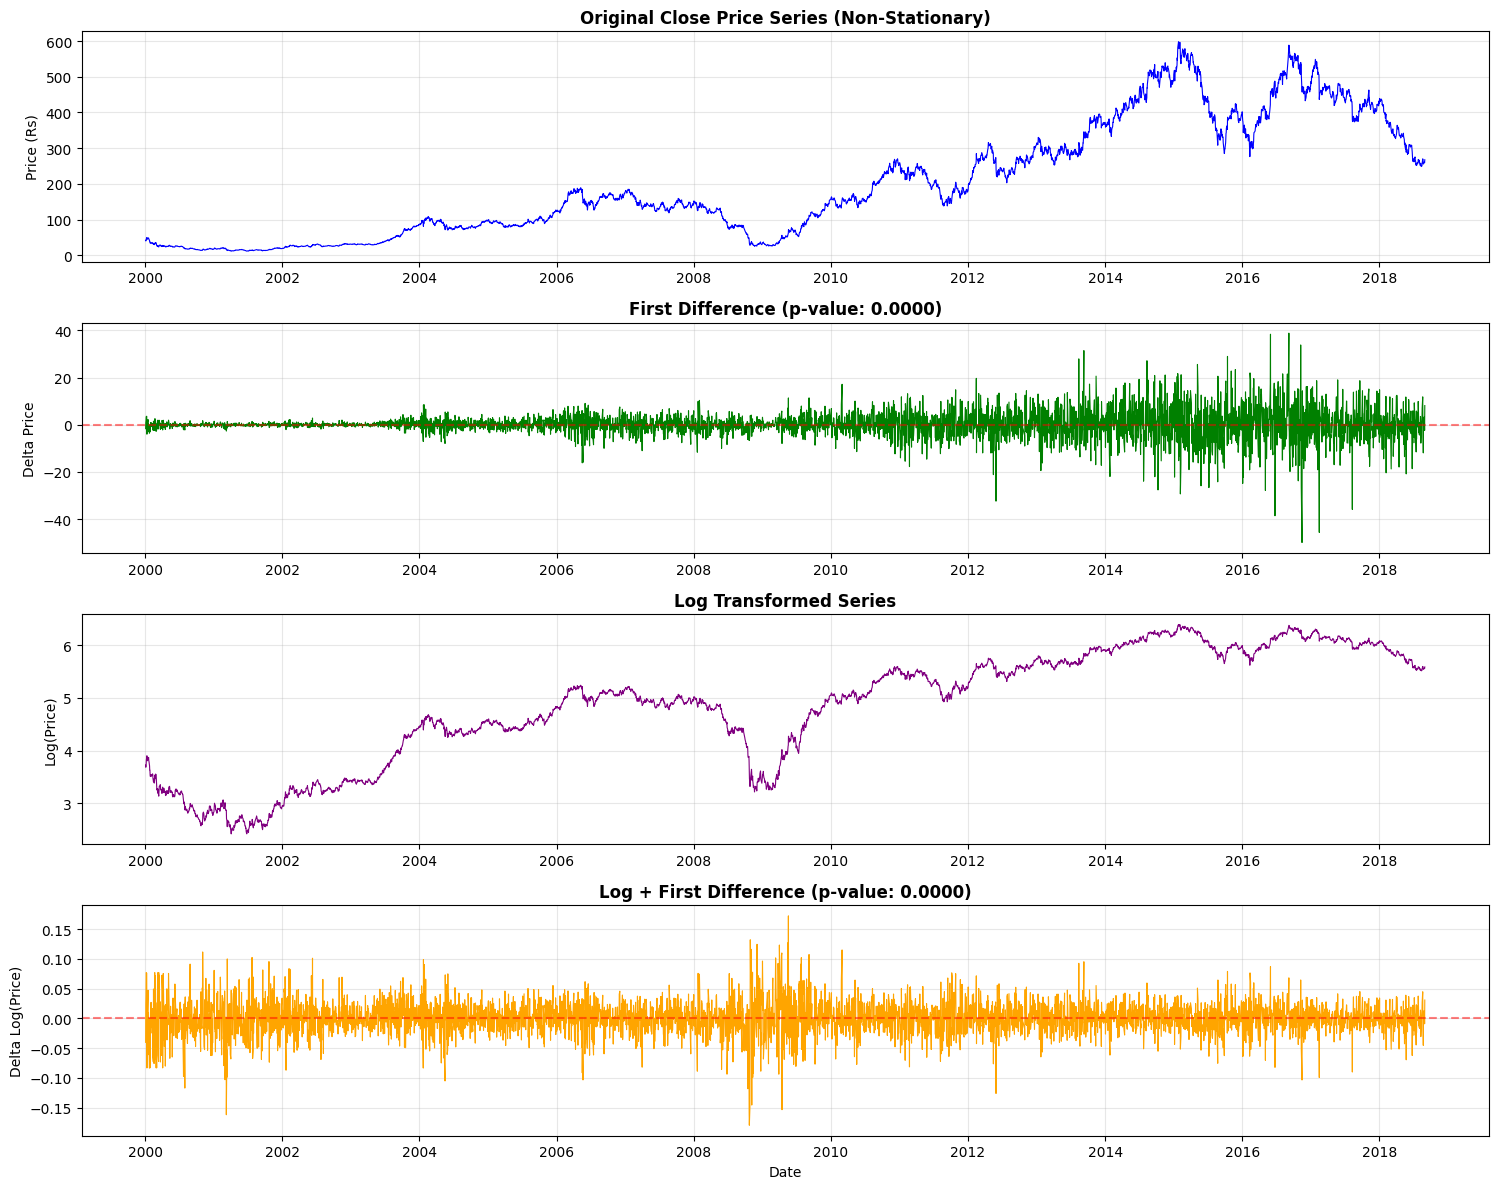


Transformation plots saved as 'transformation_comparison.png'


5.5: TRANSFORMATION SUMMARY

Stationarity Test Results (p-values):
------------------------------------------------------------
First Difference         : 0.000000  STATIONARY
Log + Difference         : 0.000000  STATIONARY

RECOMMENDED TRANSFORMATION: Log + Difference
P-value: 0.000000

Use 'close_log_diff' for modeling

Stationary series shape: (4685,)
Date range: 2000-01-04 00:00:00 to 2018-08-31 00:00:00

STEP 5: TRANSFORMATION COMPLETE


In [12]:
# ============================================================
# STEP 5: TRANSFORMATIONS TO ACHIEVE STATIONARITY
# ============================================================

print("\n" + "=" * 60)
print("STEP 5: APPLYING TRANSFORMATIONS FOR STATIONARITY")
print("=" * 60 + "\n")

# -------------------------------------------------------------
# 5.1: First Order Differencing
# -------------------------------------------------------------
print("5.1: First Order Differencing")
print("-" * 60)

# Apply first difference
close_diff1 = close_prices.diff().dropna()

# Test stationarity after first difference
adf_result_diff1 = adfuller(close_diff1, autolag='AIC')

print(f"\nFirst Difference - ADF Test Results:")
print(f"ADF Test Statistic: {adf_result_diff1[0]:.6f}")
print(f"p-value: {adf_result_diff1[1]:.6f}")
print(f"Number of Lags Used: {adf_result_diff1[2]}")
print(f"Number of Observations: {adf_result_diff1[3]}")

print("\nCritical Values:")
for key, value in adf_result_diff1[4].items():
    print(f"  {key}: {value:.4f}")

if adf_result_diff1[1] < 0.05:
    print(f"\nSTATIONARY ACHIEVED! (p-value = {adf_result_diff1[1]:.6f} < 0.05)")
    print("Reject null hypothesis - No unit root present")
    print("Data is now stationary after first differencing")
else:
    print(f"\nStill NON-STATIONARY (p-value = {adf_result_diff1[1]:.6f} > 0.05)")
    print("Need additional transformations")

# -------------------------------------------------------------
# 5.2: Second Order Differencing (if needed)
# -------------------------------------------------------------
if adf_result_diff1[1] >= 0.05:
    print("\n\n5.2: Second Order Differencing")
    print("-" * 60)
    
    # Apply second difference
    close_diff2 = close_diff1.diff().dropna()
    
    # Test stationarity after second difference
    adf_result_diff2 = adfuller(close_diff2, autolag='AIC')
    
    print(f"\nSecond Difference - ADF Test Results:")
    print(f"ADF Test Statistic: {adf_result_diff2[0]:.6f}")
    print(f"p-value: {adf_result_diff2[1]:.6f}")
    print(f"Number of Lags Used: {adf_result_diff2[2]}")
    print(f"Number of Observations: {adf_result_diff2[3]}")
    
    print("\nCritical Values:")
    for key, value in adf_result_diff2[4].items():
        print(f"  {key}: {value:.4f}")
    
    if adf_result_diff2[1] < 0.05:
        print(f"\nSTATIONARY ACHIEVED! (p-value = {adf_result_diff2[1]:.6f} < 0.05)")
        print("Data is now stationary after second differencing")
    else:
        print(f"\nStill NON-STATIONARY (p-value = {adf_result_diff2[1]:.6f} > 0.05)")

# -------------------------------------------------------------
# 5.3: Log Transformation + Differencing
# -------------------------------------------------------------
print("\n\n5.3: Log Transformation + Differencing")
print("-" * 60)

# Apply log transformation (to stabilize variance)
close_log = np.log(close_prices)

# Then difference the log-transformed data
close_log_diff = close_log.diff().dropna()

# Test stationarity
adf_result_log_diff = adfuller(close_log_diff, autolag='AIC')

print(f"\nLog + Difference - ADF Test Results:")
print(f"ADF Test Statistic: {adf_result_log_diff[0]:.6f}")
print(f"p-value: {adf_result_log_diff[1]:.6f}")
print(f"Number of Lags Used: {adf_result_log_diff[2]}")
print(f"Number of Observations: {adf_result_log_diff[3]}")

print("\nCritical Values:")
for key, value in adf_result_log_diff[4].items():
    print(f"  {key}: {value:.4f}")

if adf_result_log_diff[1] < 0.05:
    print(f"\nSTATIONARY ACHIEVED! (p-value = {adf_result_log_diff[1]:.6f} < 0.05)")
    print("Log transformation + differencing successfully achieved stationarity")
else:
    print(f"\nStill NON-STATIONARY (p-value = {adf_result_log_diff[1]:.6f} > 0.05)")

# -------------------------------------------------------------
# 5.4: Visualize Transformations
# -------------------------------------------------------------
print("\n\n5.4: Visualizing Transformations")
print("-" * 60)

fig, axes = plt.subplots(4, 1, figsize=(15, 12))

# Original Series
axes[0].plot(close_prices, color='blue', linewidth=0.8)
axes[0].set_title('Original Close Price Series (Non-Stationary)', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Price (Rs)')
axes[0].grid(True, alpha=0.3)

# First Difference
axes[1].plot(close_diff1, color='green', linewidth=0.8)
axes[1].set_title(f'First Difference (p-value: {adf_result_diff1[1]:.4f})', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Delta Price')
axes[1].grid(True, alpha=0.3)
axes[1].axhline(y=0, color='red', linestyle='--', alpha=0.5)

# Log Transformation
axes[2].plot(close_log, color='purple', linewidth=0.8)
axes[2].set_title('Log Transformed Series', fontsize=12, fontweight='bold')
axes[2].set_ylabel('Log(Price)')
axes[2].grid(True, alpha=0.3)

# Log + Difference
axes[3].plot(close_log_diff, color='orange', linewidth=0.8)
axes[3].set_title(f'Log + First Difference (p-value: {adf_result_log_diff[1]:.4f})', fontsize=12, fontweight='bold')
axes[3].set_ylabel('Delta Log(Price)')
axes[3].set_xlabel('Date')
axes[3].grid(True, alpha=0.3)
axes[3].axhline(y=0, color='red', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.savefig('transformation_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nTransformation plots saved as 'transformation_comparison.png'")

# -------------------------------------------------------------
# 5.5: Summary and Recommendation
# -------------------------------------------------------------
print("\n\n5.5: TRANSFORMATION SUMMARY")
print("=" * 60)

transformations = {
    'First Difference': adf_result_diff1[1],
    'Log + Difference': adf_result_log_diff[1]
}

print("\nStationarity Test Results (p-values):")
print("-" * 60)
for method, p_value in transformations.items():
    status = "STATIONARY" if p_value < 0.05 else "NON-STATIONARY"
    print(f"{method:25s}: {p_value:.6f}  {status}")

# Find best transformation
best_method = min(transformations, key=transformations.get)
best_p_value = transformations[best_method]

print(f"\n{'='*60}")
print(f"RECOMMENDED TRANSFORMATION: {best_method}")
print(f"P-value: {best_p_value:.6f}")
print(f"{'='*60}")

if best_method == 'First Difference':
    stationary_series = close_diff1
    print("\nUse 'close_diff1' for modeling")
else:
    stationary_series = close_log_diff
    print("\nUse 'close_log_diff' for modeling")

print(f"\nStationary series shape: {stationary_series.shape}")
print(f"Date range: {stationary_series.index[0]} to {stationary_series.index[-1]}")

print("\n" + "=" * 60)
print("STEP 5: TRANSFORMATION COMPLETE")
print("=" * 60)


# STEP 6 Seasonality, Seasonality Decomposition #


STEP 6: SEASONALITY ANALYSIS AND DECOMPOSITION

6.1: Visual Inspection for Seasonality
------------------------------------------------------------


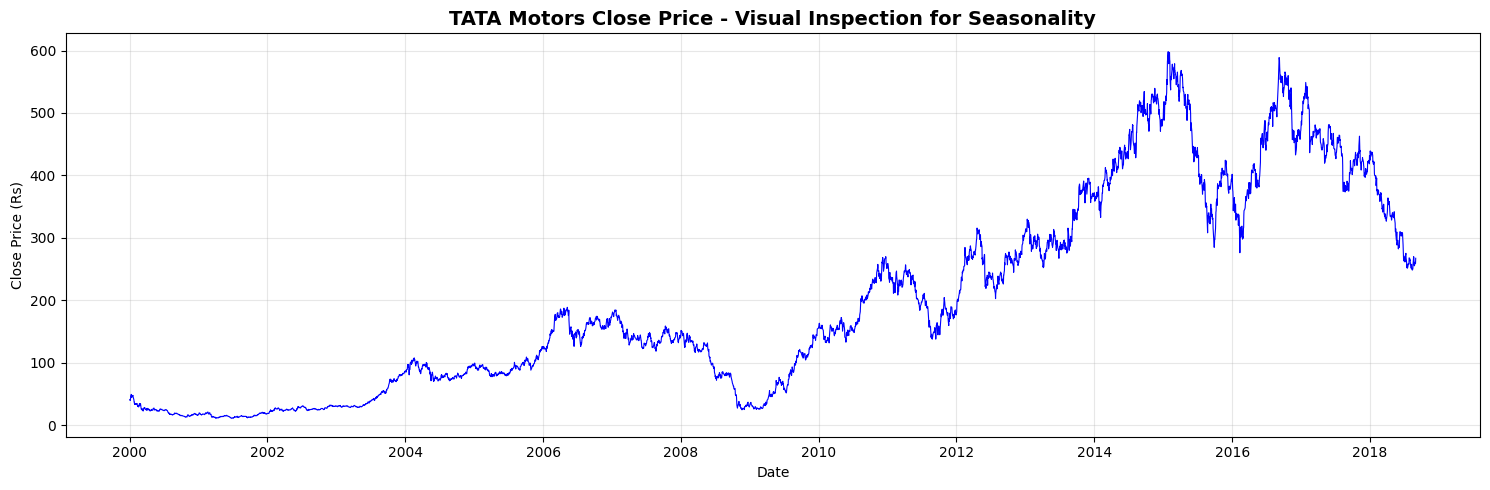

Visual inspection plot saved


6.2: Seasonal Decomposition - Additive Model
------------------------------------------------------------


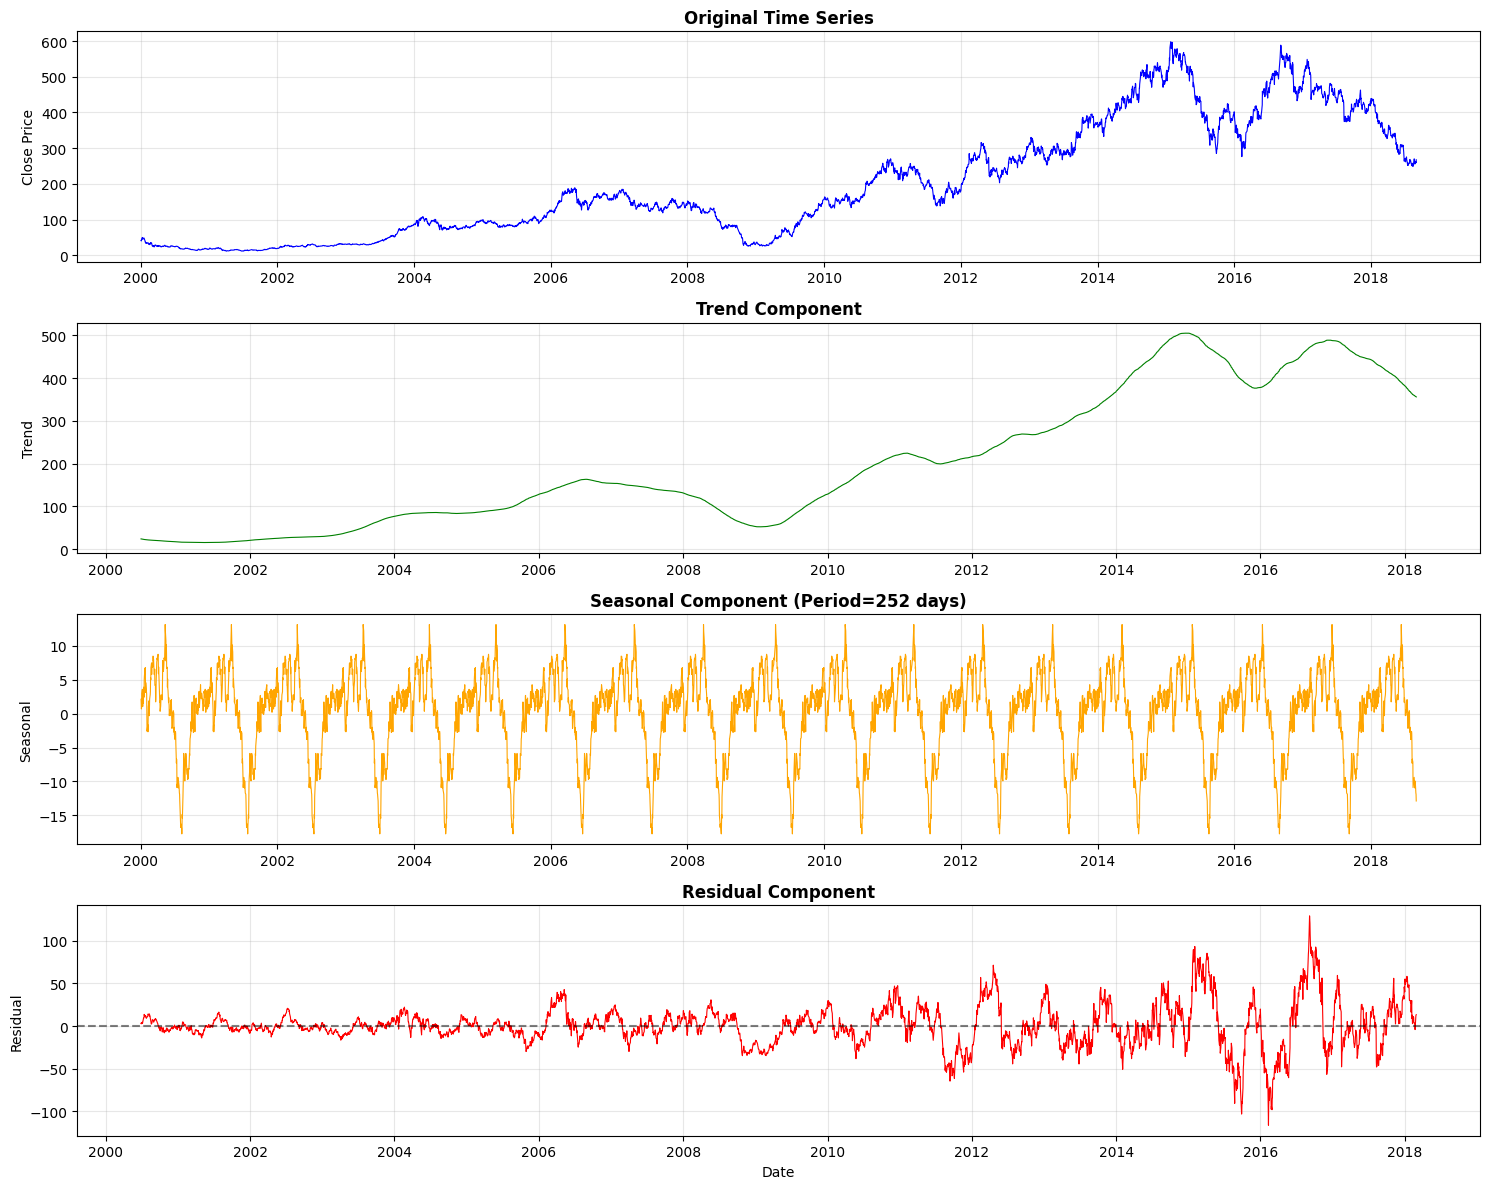

Additive decomposition completed and saved

Seasonal Component Statistics:
Mean: 0.0681
Std Dev: 6.2627
Min: -17.7428
Max: 13.1626


6.3: Seasonal Decomposition - Multiplicative Model
------------------------------------------------------------


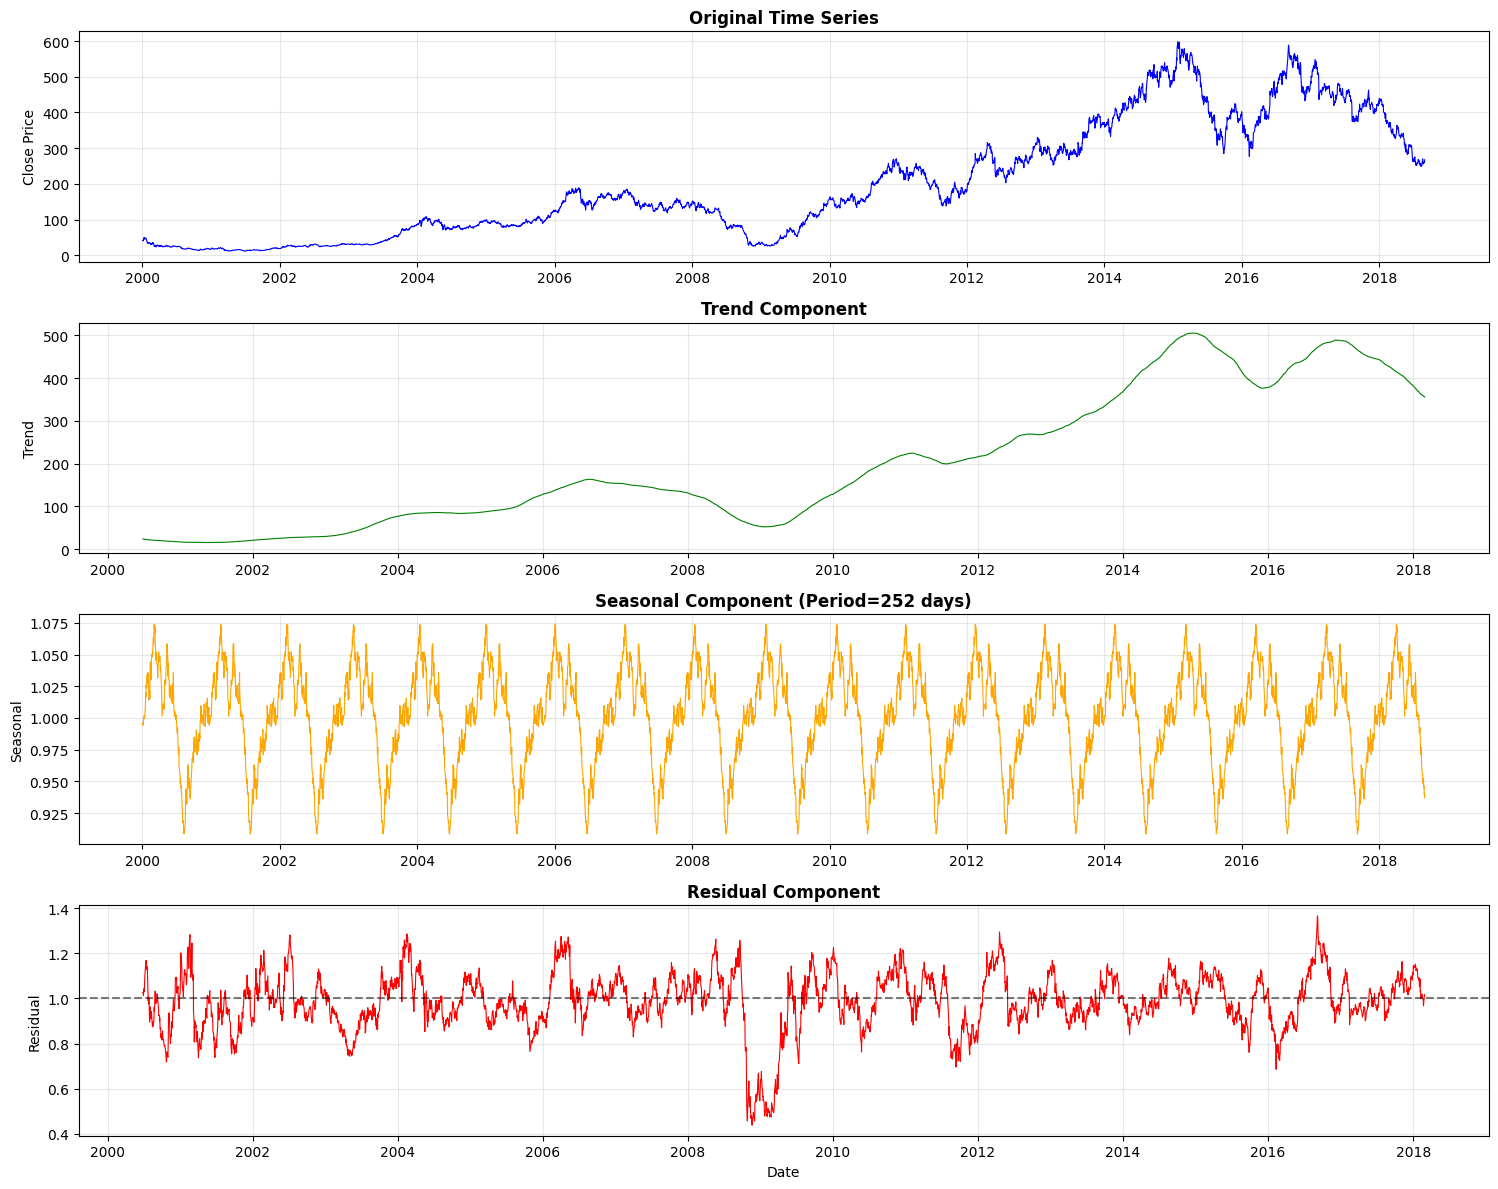

Multiplicative decomposition completed and saved

Seasonal Component Statistics:
Mean: 1.0006
Std Dev: 0.0382
Min: 0.9085
Max: 1.0737


6.4: Monthly Seasonality Analysis
------------------------------------------------------------


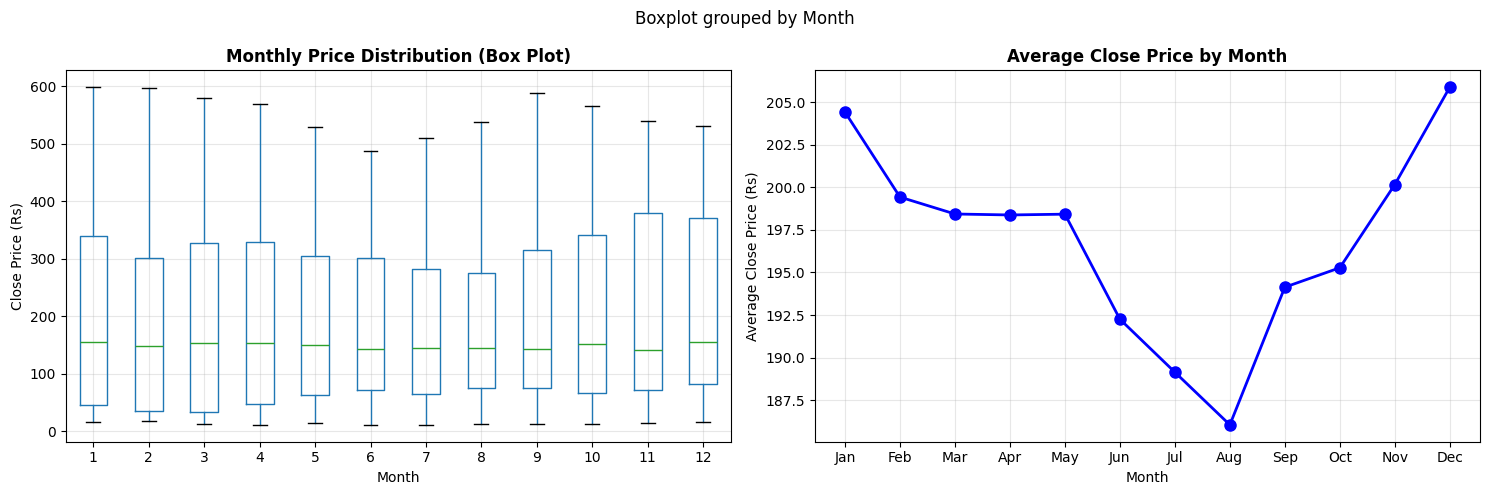


Monthly Average Prices:
----------------------------------------
Jan     : Rs 204.42
Feb     : Rs 199.43
Mar     : Rs 198.44
Apr     : Rs 198.38
May     : Rs 198.43
Jun     : Rs 192.25
Jul     : Rs 189.14
Aug     : Rs 186.05
Sep     : Rs 194.14
Oct     : Rs 195.28
Nov     : Rs 200.16
Dec     : Rs 205.88


6.5: Quarterly Seasonality Analysis
------------------------------------------------------------


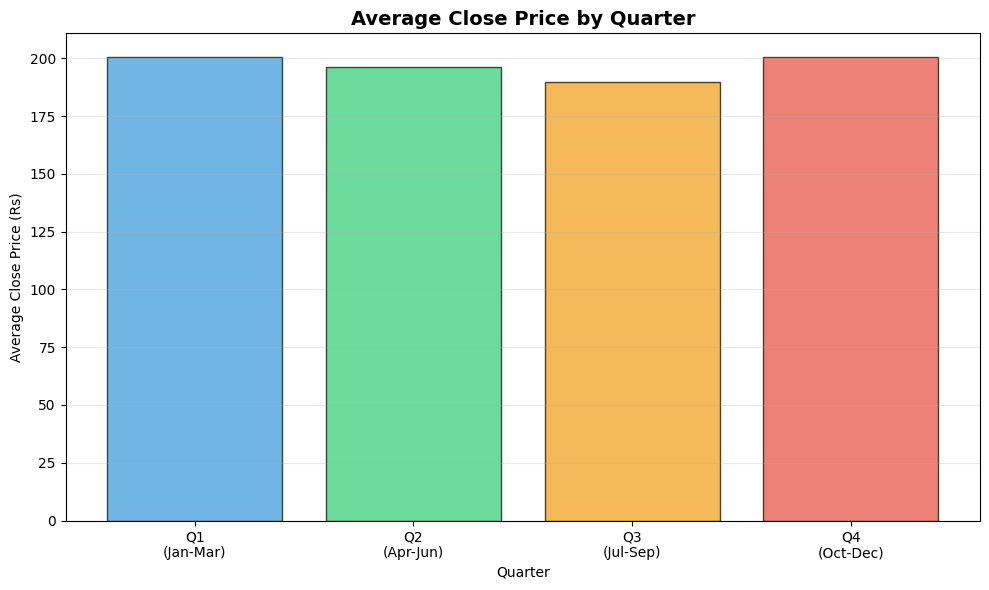


Quarterly Average Prices:
----------------------------------------
Q1: Rs 200.80
Q2: Rs 196.31
Q3: Rs 189.65
Q4: Rs 200.52


6.6: Day of Week Analysis
------------------------------------------------------------


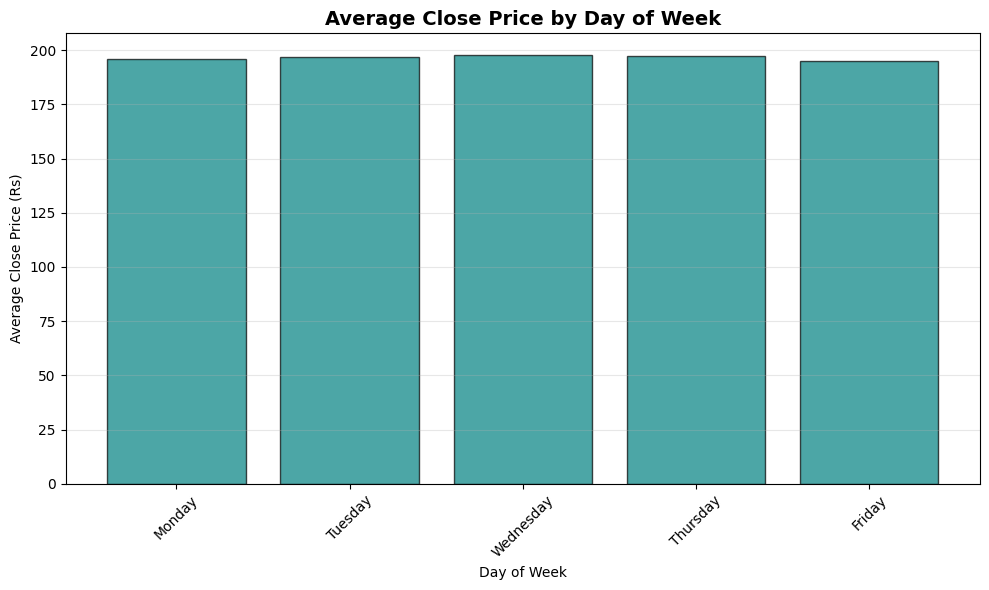


Day of Week Average Prices:
----------------------------------------
Monday      : Rs 196.08
Tuesday     : Rs 196.76
Wednesday   : Rs 197.82
Thursday    : Rs 197.18
Friday      : Rs 195.11


6.7: SEASONALITY SUMMARY

Key Findings:
------------------------------------------------------------
1. Seasonal Decomposition:
   - Trend component shows long-term price movement
   - Seasonal component shows cyclical patterns (if any)
   - Residual component shows random fluctuations

2. Monthly Patterns:
   - Highest average price: Dec (Rs 205.88)
   - Lowest average price: Aug (Rs 186.05)

3. Quarterly Patterns:
   - Highest average price: Q1 (Rs 200.80)
   - Lowest average price: Q3 (Rs 189.65)

4. Day of Week Patterns:
   - Highest average price: Wednesday (Rs 197.82)
   - Lowest average price: Friday (Rs 195.11)

STEP 6: SEASONALITY ANALYSIS COMPLETE

Note: For financial time series like stock prices,
seasonality is often weak or absent. Focus on trend and residuals.


In [13]:
# ============================================================
# STEP 6: CHECK SEASONALITY AND SEASONAL DECOMPOSITION
# ============================================================

print("\n" + "=" * 60)
print("STEP 6: SEASONALITY ANALYSIS AND DECOMPOSITION")
print("=" * 60 + "\n")

# Import required libraries for seasonal decomposition
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# -------------------------------------------------------------
# 6.1: Visual Inspection for Seasonality
# -------------------------------------------------------------
print("6.1: Visual Inspection for Seasonality")
print("-" * 60)

# Plot the original time series
plt.figure(figsize=(15, 5))
plt.plot(close_prices, color='blue', linewidth=0.8)
plt.title('TATA Motors Close Price - Visual Inspection for Seasonality', fontsize=14, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Close Price (Rs)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('seasonality_visual_inspection.png', dpi=300, bbox_inches='tight')
plt.show()

print("Visual inspection plot saved")

# -------------------------------------------------------------
# 6.2: Seasonal Decomposition (Additive Model)
# -------------------------------------------------------------
print("\n\n6.2: Seasonal Decomposition - Additive Model")
print("-" * 60)

# Perform seasonal decomposition (Additive)
# For stock data, we typically use period=252 (trading days in a year)
# or period=12 for monthly data, period=4 for quarterly data

try:
    decomposition_add = seasonal_decompose(close_prices, model='additive', period=252)
    
    # Plot decomposition
    fig, axes = plt.subplots(4, 1, figsize=(15, 12))
    
    # Original series
    axes[0].plot(close_prices, color='blue', linewidth=0.8)
    axes[0].set_title('Original Time Series', fontsize=12, fontweight='bold')
    axes[0].set_ylabel('Close Price')
    axes[0].grid(True, alpha=0.3)
    
    # Trend component
    axes[1].plot(decomposition_add.trend, color='green', linewidth=0.8)
    axes[1].set_title('Trend Component', fontsize=12, fontweight='bold')
    axes[1].set_ylabel('Trend')
    axes[1].grid(True, alpha=0.3)
    
    # Seasonal component
    axes[2].plot(decomposition_add.seasonal, color='orange', linewidth=0.8)
    axes[2].set_title('Seasonal Component (Period=252 days)', fontsize=12, fontweight='bold')
    axes[2].set_ylabel('Seasonal')
    axes[2].grid(True, alpha=0.3)
    
    # Residual component
    axes[3].plot(decomposition_add.resid, color='red', linewidth=0.8)
    axes[3].set_title('Residual Component', fontsize=12, fontweight='bold')
    axes[3].set_ylabel('Residual')
    axes[3].set_xlabel('Date')
    axes[3].grid(True, alpha=0.3)
    axes[3].axhline(y=0, color='black', linestyle='--', alpha=0.5)
    
    plt.tight_layout()
    plt.savefig('seasonal_decomposition_additive.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("Additive decomposition completed and saved")
    
    # Statistics of seasonal component
    print(f"\nSeasonal Component Statistics:")
    print(f"Mean: {decomposition_add.seasonal.mean():.4f}")
    print(f"Std Dev: {decomposition_add.seasonal.std():.4f}")
    print(f"Min: {decomposition_add.seasonal.min():.4f}")
    print(f"Max: {decomposition_add.seasonal.max():.4f}")
    
except Exception as e:
    print(f"Error in additive decomposition: {e}")
    print("Note: Need at least 2 complete cycles for seasonal decomposition")

# -------------------------------------------------------------
# 6.3: Seasonal Decomposition (Multiplicative Model)
# -------------------------------------------------------------
print("\n\n6.3: Seasonal Decomposition - Multiplicative Model")
print("-" * 60)

try:
    decomposition_mult = seasonal_decompose(close_prices, model='multiplicative', period=252)
    
    # Plot decomposition
    fig, axes = plt.subplots(4, 1, figsize=(15, 12))
    
    # Original series
    axes[0].plot(close_prices, color='blue', linewidth=0.8)
    axes[0].set_title('Original Time Series', fontsize=12, fontweight='bold')
    axes[0].set_ylabel('Close Price')
    axes[0].grid(True, alpha=0.3)
    
    # Trend component
    axes[1].plot(decomposition_mult.trend, color='green', linewidth=0.8)
    axes[1].set_title('Trend Component', fontsize=12, fontweight='bold')
    axes[1].set_ylabel('Trend')
    axes[1].grid(True, alpha=0.3)
    
    # Seasonal component
    axes[2].plot(decomposition_mult.seasonal, color='orange', linewidth=0.8)
    axes[2].set_title('Seasonal Component (Period=252 days)', fontsize=12, fontweight='bold')
    axes[2].set_ylabel('Seasonal')
    axes[2].grid(True, alpha=0.3)
    
    # Residual component
    axes[3].plot(decomposition_mult.resid, color='red', linewidth=0.8)
    axes[3].set_title('Residual Component', fontsize=12, fontweight='bold')
    axes[3].set_ylabel('Residual')
    axes[3].set_xlabel('Date')
    axes[3].grid(True, alpha=0.3)
    axes[3].axhline(y=1, color='black', linestyle='--', alpha=0.5)
    
    plt.tight_layout()
    plt.savefig('seasonal_decomposition_multiplicative.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("Multiplicative decomposition completed and saved")
    
    # Statistics of seasonal component
    print(f"\nSeasonal Component Statistics:")
    print(f"Mean: {decomposition_mult.seasonal.mean():.4f}")
    print(f"Std Dev: {decomposition_mult.seasonal.std():.4f}")
    print(f"Min: {decomposition_mult.seasonal.min():.4f}")
    print(f"Max: {decomposition_mult.seasonal.max():.4f}")
    
except Exception as e:
    print(f"Error in multiplicative decomposition: {e}")
    print("Note: Need at least 2 complete cycles for seasonal decomposition")

# -------------------------------------------------------------
# 6.4: Monthly Seasonality Analysis
# -------------------------------------------------------------
print("\n\n6.4: Monthly Seasonality Analysis")
print("-" * 60)

# Extract month from date index
close_prices_monthly = close_prices.copy()
close_prices_df = pd.DataFrame(close_prices_monthly)
close_prices_df['Month'] = close_prices_df.index.month
close_prices_df['Year'] = close_prices_df.index.year

# Calculate average price by month
monthly_avg = close_prices_df.groupby('Month')['Close'].mean()

# Plot monthly seasonality
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Box plot by month
close_prices_df.boxplot(column='Close', by='Month', ax=axes[0])
axes[0].set_title('Monthly Price Distribution (Box Plot)', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Month')
axes[0].set_ylabel('Close Price (Rs)')
axes[0].grid(True, alpha=0.3)

# Average price by month
axes[1].plot(monthly_avg.index, monthly_avg.values, marker='o', color='blue', linewidth=2, markersize=8)
axes[1].set_title('Average Close Price by Month', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Month')
axes[1].set_ylabel('Average Close Price (Rs)')
axes[1].set_xticks(range(1, 13))
axes[1].set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('monthly_seasonality.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nMonthly Average Prices:")
print("-" * 40)
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
for month, avg_price in monthly_avg.items():
    print(f"{month_names[month-1]:8s}: Rs {avg_price:.2f}")

# -------------------------------------------------------------
# 6.5: Quarterly Seasonality Analysis
# -------------------------------------------------------------
print("\n\n6.5: Quarterly Seasonality Analysis")
print("-" * 60)

# Extract quarter from date index
close_prices_df['Quarter'] = close_prices_df.index.quarter

# Calculate average price by quarter
quarterly_avg = close_prices_df.groupby('Quarter')['Close'].mean()

# Plot quarterly seasonality
plt.figure(figsize=(10, 6))
plt.bar(quarterly_avg.index, quarterly_avg.values, color=['#3498db', '#2ecc71', '#f39c12', '#e74c3c'], alpha=0.7, edgecolor='black')
plt.title('Average Close Price by Quarter', fontsize=14, fontweight='bold')
plt.xlabel('Quarter')
plt.ylabel('Average Close Price (Rs)')
plt.xticks([1, 2, 3, 4], ['Q1\n(Jan-Mar)', 'Q2\n(Apr-Jun)', 'Q3\n(Jul-Sep)', 'Q4\n(Oct-Dec)'])
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.savefig('quarterly_seasonality.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nQuarterly Average Prices:")
print("-" * 40)
for quarter, avg_price in quarterly_avg.items():
    print(f"Q{quarter}: Rs {avg_price:.2f}")

# -------------------------------------------------------------
# 6.6: Day-of-Week Analysis
# -------------------------------------------------------------
print("\n\n6.6: Day of Week Analysis")
print("-" * 60)

# Extract day of week
close_prices_df['DayOfWeek'] = close_prices_df.index.dayofweek

# Calculate average price by day of week
dow_avg = close_prices_df.groupby('DayOfWeek')['Close'].mean()

# Plot day of week seasonality
plt.figure(figsize=(10, 6))
day_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']
plt.bar(range(5), dow_avg.values[:5], color='teal', alpha=0.7, edgecolor='black')
plt.title('Average Close Price by Day of Week', fontsize=14, fontweight='bold')
plt.xlabel('Day of Week')
plt.ylabel('Average Close Price (Rs)')
plt.xticks(range(5), day_names, rotation=45)
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.savefig('day_of_week_seasonality.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nDay of Week Average Prices:")
print("-" * 40)
for day, avg_price in dow_avg.items():
    if day < 5:  # Only trading days
        print(f"{day_names[day]:12s}: Rs {avg_price:.2f}")

# -------------------------------------------------------------
# 6.7: Summary of Seasonality Analysis
# -------------------------------------------------------------
print("\n\n6.7: SEASONALITY SUMMARY")
print("=" * 60)

print("\nKey Findings:")
print("-" * 60)
print("1. Seasonal Decomposition:")
print("   - Trend component shows long-term price movement")
print("   - Seasonal component shows cyclical patterns (if any)")
print("   - Residual component shows random fluctuations")

print("\n2. Monthly Patterns:")
highest_month = monthly_avg.idxmax()
lowest_month = monthly_avg.idxmin()
print(f"   - Highest average price: {month_names[highest_month-1]} (Rs {monthly_avg[highest_month]:.2f})")
print(f"   - Lowest average price: {month_names[lowest_month-1]} (Rs {monthly_avg[lowest_month]:.2f})")

print("\n3. Quarterly Patterns:")
highest_quarter = quarterly_avg.idxmax()
lowest_quarter = quarterly_avg.idxmin()
print(f"   - Highest average price: Q{highest_quarter} (Rs {quarterly_avg[highest_quarter]:.2f})")
print(f"   - Lowest average price: Q{lowest_quarter} (Rs {quarterly_avg[lowest_quarter]:.2f})")

print("\n4. Day of Week Patterns:")
if len(dow_avg) >= 5:
    highest_dow = dow_avg[:5].idxmax()
    lowest_dow = dow_avg[:5].idxmin()
    print(f"   - Highest average price: {day_names[highest_dow]} (Rs {dow_avg[highest_dow]:.2f})")
    print(f"   - Lowest average price: {day_names[lowest_dow]} (Rs {dow_avg[lowest_dow]:.2f})")

print("\n" + "=" * 60)
print("STEP 6: SEASONALITY ANALYSIS COMPLETE")
print("=" * 60)
print("\nNote: For financial time series like stock prices,")
print("seasonality is often weak or absent. Focus on trend and residuals.")


# STEP 7 ACF, PACF plots #


STEP 7: AUTOCORRELATION (ACF) & PARTIAL AUTOCORRELATION (PACF)

7.1: ACF Plot
------------------------------------------------------------

7.2: PACF Plot
------------------------------------------------------------


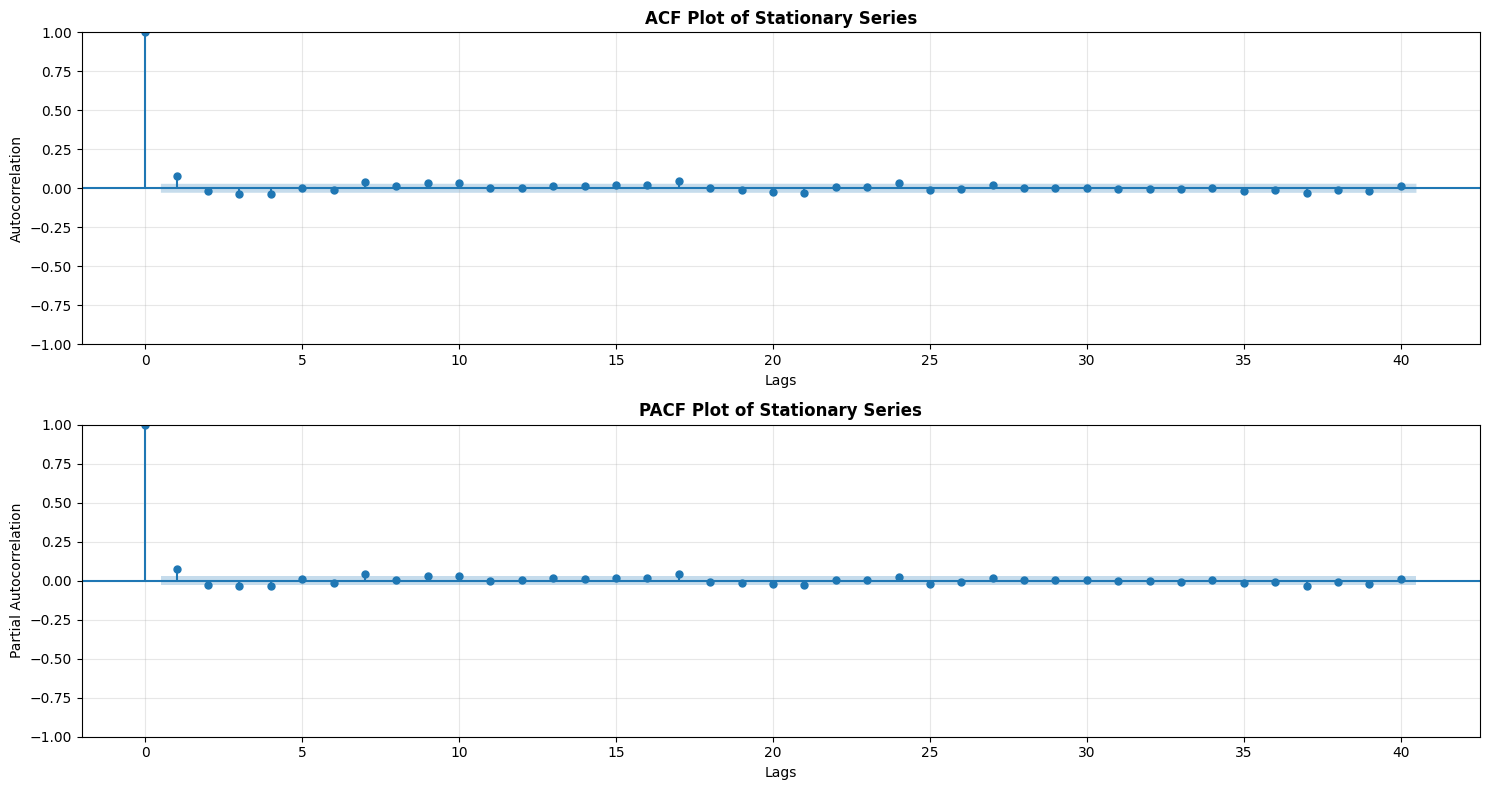

ACF and PACF plots saved as 'acf_pacf_plots.png'

Interpretation:
- ACF helps to identify the order of MA (Moving Average) terms.
- PACF helps to identify the order of AR (AutoRegressive) terms.
- Look for where ACF/PACF plots cross the significance interval for optimal lag selection.


In [14]:
# ============================================================
# STEP 7: ACF, PACF PLOTS
# ============================================================

print("\n" + "=" * 60)
print("STEP 7: AUTOCORRELATION (ACF) & PARTIAL AUTOCORRELATION (PACF)")
print("=" * 60 + "\n")

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Assuming 'stationary_series' is the differenced/log-differenced series 
# from Step 5 that achieved stationarity.

fig, axes = plt.subplots(2, 1, figsize=(15, 8))

# -------------------------------------------------------------
# 7.1: ACF Plot
# -------------------------------------------------------------
print("7.1: ACF Plot")
print("-" * 60)
plot_acf(stationary_series.dropna(), lags=40, ax=axes[0], alpha=0.05)
axes[0].set_title('ACF Plot of Stationary Series', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Lags')
axes[0].set_ylabel('Autocorrelation')
axes[0].grid(True, alpha=0.3)

# -------------------------------------------------------------
# 7.2: PACF Plot
# -------------------------------------------------------------
print("\n7.2: PACF Plot")
print("-" * 60)
plot_pacf(stationary_series.dropna(), lags=40, ax=axes[1], method='ywm', alpha=0.05)
axes[1].set_title('PACF Plot of Stationary Series', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Lags')
axes[1].set_ylabel('Partial Autocorrelation')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('acf_pacf_plots.png', dpi=300, bbox_inches='tight')
plt.show()

print("ACF and PACF plots saved as 'acf_pacf_plots.png'")

print("\nInterpretation:")
print("- ACF helps to identify the order of MA (Moving Average) terms.")
print("- PACF helps to identify the order of AR (AutoRegressive) terms.")
print("- Look for where ACF/PACF plots cross the significance interval for optimal lag selection.")


# STEP 8 Identify if AR, MA, ARMA, ARIMA, SARIMA model #

In [15]:
# ============================================================
# STEP 8: MODEL IDENTIFICATION - AR, MA, ARMA, ARIMA, SARIMA
# ============================================================

print("\n" + "=" * 60)
print("STEP 8: MODEL IDENTIFICATION & FITTING")
print("=" * 60 + "\n")

from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA, ARIMAResults
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Use the stationary series (from Step 5, eg. close_diff1 or close_log_diff)
series = stationary_series.dropna()

# 8.1 - Fit AR Model (AutoRegressive)
print("--- AR Model ---")
try:
    ar_model = AutoReg(series, lags=1).fit()
    print(ar_model.summary())
except Exception as e:
    print(f"AR Model error: {e}")

# 8.2 - Fit MA Model (Moving Average) using ARIMA(order=(0,0,q))
print("\n--- MA Model ---")
try:
    ma_model = ARIMA(series, order=(0,0,1)).fit()
    print(ma_model.summary())
except Exception as e:
    print(f"MA Model error: {e}")

# 8.3 - Fit ARMA Model (AutoRegressive Moving Average)
print("\n--- ARMA Model ---")
try:
    arma_model = ARIMA(series, order=(1,0,1)).fit()
    print(arma_model.summary())
except Exception as e:
    print(f"ARMA Model error: {e}")

# 8.4 - Fit ARIMA Model (with differencing d=1 if first diff, or d=0 if series already differenced)
print("\n--- ARIMA Model ---")
try:
    # Here, p and q can be selected based on ACF/PACF and best parameters
    arima_model = ARIMA(series, order=(1,0,1)).fit()
    print(arima_model.summary())
except Exception as e:
    print(f"ARIMA Model error: {e}")

# 8.5 - Fit SARIMA Model (Seasonal ARIMA)
print("\n--- SARIMA Model ---")
try:
    # Example seasonal order (p,d,q,P,D,Q,s) -> (1,0,1,0,1,1,12)
    sarima_model = SARIMAX(series, order=(1,0,1), seasonal_order=(0,1,1,12)).fit(disp=False)
    print(sarima_model.summary())
except Exception as e:
    print(f"SARIMA Model error: {e}")

print("\nCompare AIC/BIC of each model to choose best!")
print("Look for minimum AIC/BIC. Use summary tables above.")



STEP 8: MODEL IDENTIFICATION & FITTING

--- AR Model ---
                            AutoReg Model Results                             
Dep. Variable:                  Close   No. Observations:                 4685
Model:                     AutoReg(1)   Log Likelihood               10215.678
Method:               Conditional MLE   S.D. of innovations              0.027
Date:                Sat, 25 Oct 2025   AIC                         -20425.355
Time:                        18:15:17   BIC                         -20406.000
Sample:                             1   HQIC                        -20418.549
                                 4685                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0004      0.000      0.941      0.347      -0.000       0.001
Close.L1       0.0780      0.015      5.358      0.000       0.049       

d:\Anaconda_installation\envs\ats_project\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Anaconda_installation\envs\ats_project\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Anaconda_installation\envs\ats_project\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Anaconda_installation\envs\ats_project\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency informatio

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 4685
Model:                 ARIMA(0, 0, 1)   Log Likelihood               10217.796
Date:                Sat, 25 Oct 2025   AIC                         -20429.593
Time:                        18:15:18   BIC                         -20410.236
Sample:                             0   HQIC                        -20422.786
                               - 4685                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0004      0.000      0.913      0.361      -0.000       0.001
ma.L1          0.0791      0.010      7.899      0.000       0.060       0.099
sigma2         0.0007   9.63e-06     77.493      0.0

d:\Anaconda_installation\envs\ats_project\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Anaconda_installation\envs\ats_project\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Anaconda_installation\envs\ats_project\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 4685
Model:                 ARIMA(1, 0, 1)   Log Likelihood               10218.031
Date:                Sat, 25 Oct 2025   AIC                         -20428.062
Time:                        18:15:18   BIC                         -20402.254
Sample:                             0   HQIC                        -20418.987
                               - 4685                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0004      0.000      0.918      0.359      -0.000       0.001
ar.L1         -0.0781      0.120     -0.649      0.516      -0.314       0.158
ma.L1          0.1573      0.122      1.285      0.1

d:\Anaconda_installation\envs\ats_project\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Anaconda_installation\envs\ats_project\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Anaconda_installation\envs\ats_project\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 4685
Model:                 ARIMA(1, 0, 1)   Log Likelihood               10218.031
Date:                Sat, 25 Oct 2025   AIC                         -20428.062
Time:                        18:15:19   BIC                         -20402.254
Sample:                             0   HQIC                        -20418.987
                               - 4685                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0004      0.000      0.918      0.359      -0.000       0.001
ar.L1         -0.0781      0.120     -0.649      0.516      -0.314       0.158
ma.L1          0.1573      0.122      1.285      0.1

d:\Anaconda_installation\envs\ats_project\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Anaconda_installation\envs\ats_project\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Anaconda_installation\envs\ats_project\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                     SARIMAX Results                                      
Dep. Variable:                              Close   No. Observations:                 4685
Model:             SARIMAX(1, 0, 1)x(0, 1, 1, 12)   Log Likelihood               10158.017
Date:                            Sat, 25 Oct 2025   AIC                         -20308.035
Time:                                    18:15:27   BIC                         -20282.236
Sample:                                         0   HQIC                        -20298.962
                                           - 4685                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1081      0.122     -0.889      0.374      -0.346       0.130
ma.L1          0.1880      0.123   

Step 9

In [16]:
# ============================================================
# STEP 9: IDENTIFY LAGS (AR p, MA q) USING GRID SEARCH
# ============================================================

import itertools
import warnings
warnings.filterwarnings("ignore")

series = stationary_series.dropna()  # From Step 5

p = q = range(0, 5)
pq_combinations = list(itertools.product(p, q))

aic_values = []
bic_values = []

print("=" * 60)
print("STEP 9: GRID SEARCH FOR OPTIMAL LAGS (p and q)")
print("=" * 60, "\n")

for order in pq_combinations:
    try:
        model = ARIMA(series, order=(order[0], 0, order[1]))
        fit = model.fit()
        aic_values.append((order, fit.aic))
        bic_values.append((order, fit.bic))
    except:
        continue

aic_sorted = sorted(aic_values, key=lambda x: x[1])[:10]
bic_sorted = sorted(bic_values, key=lambda x: x[1])[:10]

print("Top 10 by AIC:")
for o, a in aic_sorted:
    print(f"ARIMA{o} -> AIC = {a:.2f}")

print("\nTop 10 by BIC:")
for o, b in bic_sorted:
    print(f"ARIMA{o} -> BIC = {b:.2f}")

best_order = aic_sorted[0][0]
print(f"\nBest order by AIC: ARIMA{best_order}")


STEP 9: GRID SEARCH FOR OPTIMAL LAGS (p and q)

Top 10 by AIC:
ARIMA(3, 3) -> AIC = -20437.99
ARIMA(4, 0) -> AIC = -20435.44
ARIMA(2, 2) -> AIC = -20435.31
ARIMA(0, 4) -> AIC = -20435.12
ARIMA(4, 1) -> AIC = -20433.53
ARIMA(1, 4) -> AIC = -20433.12
ARIMA(3, 0) -> AIC = -20432.34
ARIMA(4, 2) -> AIC = -20431.57
ARIMA(4, 4) -> AIC = -20431.12
ARIMA(0, 3) -> AIC = -20430.82

Top 10 by BIC:
ARIMA(0, 1) -> BIC = -20410.24
ARIMA(1, 0) -> BIC = -20409.16
ARIMA(2, 0) -> BIC = -20403.42
ARIMA(0, 2) -> BIC = -20402.63
ARIMA(1, 1) -> BIC = -20402.25
ARIMA(3, 0) -> BIC = -20400.08
ARIMA(0, 3) -> BIC = -20398.56
ARIMA(1, 2) -> BIC = -20398.25
ARIMA(4, 0) -> BIC = -20396.72
ARIMA(2, 2) -> BIC = -20396.59

Best order by AIC: ARIMA(3, 3)


Step 10

In [18]:
# ============================================================
# STEP 10: AIC/BIC MODEL COMPARISON AND FINAL MODEL FIT
# ============================================================

print("=" * 60)
print("STEP 10: AIC/BIC MODEL COMPARISON")
print("=" * 60, "\n")

# Ensure order is 3-element tuple (p, d, q)
# Since series is already differenced (stationary), d=0
p, q = best_order
final_order = (int(p), 0, int(q))

# Fit ARIMA(p, d, q)
final_model = ARIMA(series, order=final_order).fit()

print(f"Fitted Model: ARIMA{final_order}")
print("=" * 60)
print(final_model.summary())

print("\nModel Information Criteria:")
print(f"AIC: {final_model.aic:.4f}")
print(f"BIC: {final_model.bic:.4f}")
print(f"Log-Likelihood: {final_model.llf:.4f}")


STEP 10: AIC/BIC MODEL COMPARISON

Fitted Model: ARIMA(3, 0, 3)
                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 4685
Model:                 ARIMA(3, 0, 3)   Log Likelihood               10226.994
Date:                Sat, 25 Oct 2025   AIC                         -20437.988
Time:                        18:21:41   BIC                         -20386.371
Sample:                             0   HQIC                        -20419.837
                               - 4685                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0004      0.000      0.978      0.328      -0.000       0.001
ar.L1          0.4037      0.113      3.565      0.000       0.182 

Step 11

STEP 11: MODEL DEPLOYMENT - FORECAST & EXPORT



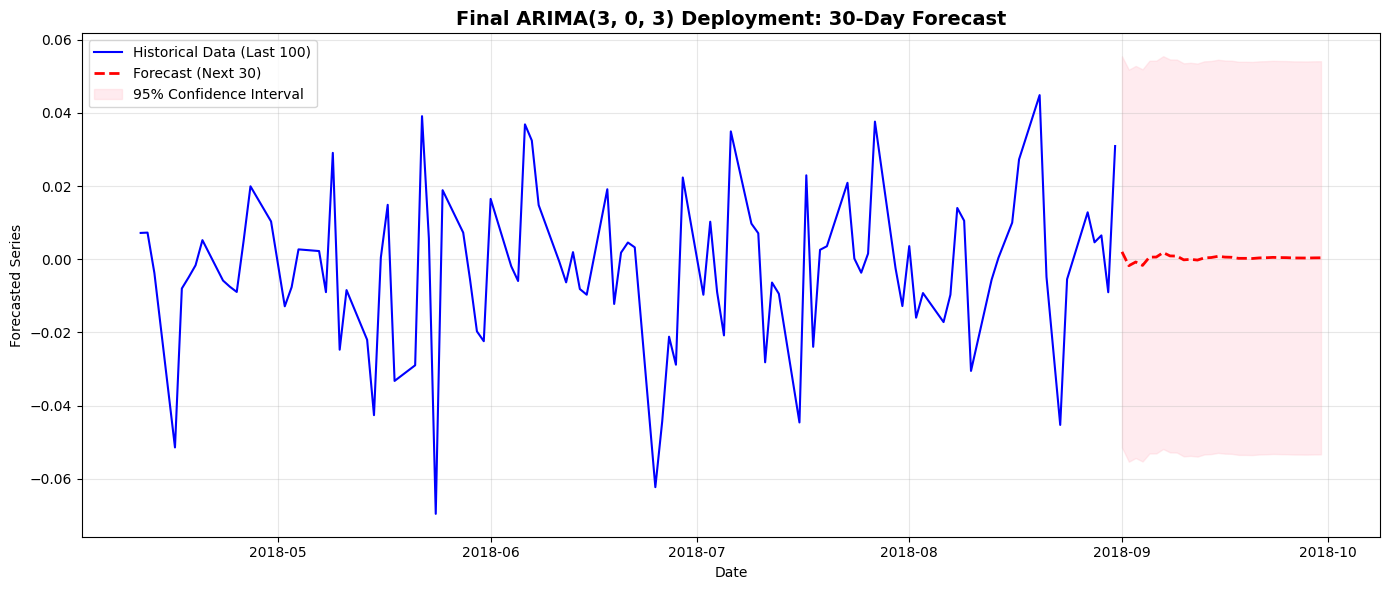

Model saved as 'final_arima_model.pkl'
Forecast results exported to 'forecast_output.csv'


In [20]:
# ============================================================
# STEP 11: DEPLOY THE FINAL MODEL (FIXED)
# ============================================================

import pickle

print("=" * 60)
print("STEP 11: MODEL DEPLOYMENT - FORECAST & EXPORT")
print("=" * 60, "\n")

# expand best_order to 3 elements: (p, d, q)
p, q = best_order
final_order = (int(p), 0, int(q))  # d = 0 because data already differenced

# Refit on entire stationary series
deployed_model = ARIMA(series, order=final_order).fit()

# Forecast next 30 days
forecast_horizon = 30
forecast_obj = deployed_model.get_forecast(steps=forecast_horizon)
forecast_mean = forecast_obj.predicted_mean
forecast_ci = forecast_obj.conf_int()

# Create forecast index
last_date = series.index[-1]
future_dates = pd.date_range(
    start=last_date + pd.Timedelta(days=1),
    periods=forecast_horizon,
    freq="D"
)

# Plot forecast
plt.figure(figsize=(14, 6))
plt.plot(series.index[-100:], series[-100:], color='blue', label='Historical Data (Last 100)')
plt.plot(future_dates, forecast_mean, color='red', linestyle='--', linewidth=2, label='Forecast (Next 30)')
plt.fill_between(future_dates,
                 forecast_ci.iloc[:, 0],
                 forecast_ci.iloc[:, 1],
                 color='pink', alpha=0.3, label='95% Confidence Interval')
plt.title(f'Final ARIMA{final_order} Deployment: 30‑Day Forecast', fontsize=14, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Forecasted Series')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Save deployed model
with open('final_arima_model.pkl', 'wb') as f:
    pickle.dump(deployed_model, f)
print("Model saved as 'final_arima_model.pkl'")

# Export forecast results
forecast_df = pd.DataFrame({
    "Date": future_dates,
    "Forecast": forecast_mean.values,
    "Lower_95": forecast_ci.iloc[:, 0].values,
    "Upper_95": forecast_ci.iloc[:, 1].values
})
forecast_df.to_csv("forecast_output.csv", index=False)
print("Forecast results exported to 'forecast_output.csv'")
